# ALL ABOUT CHESS

### Francisco Morales, Kevin Peachey

Imports:

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("games.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## Introduction

## Data Cleaning

### Missing values

### Outlier games

Since this dataset is a collection of games that were played online, there may be games that ended for reasons outside of the game itself. For instance, a player may resign if they have an obligation in the real world to attend to, irrespective of the current board position. Games may also end if a player loses connection during the match. These games introduce noise into our analysis, since their outcomes may have nothing to do with the moves played.

While there is no way to detect all of these games, we can use domain knowledge to elimate some of them. For instace, sometimes a player will leave an online match before they play any moves because they started a new game accidentally. Since it is very rare for a chess game to end after few moves, games that have only a few moves are most likely outliers in which a player had to leave early.

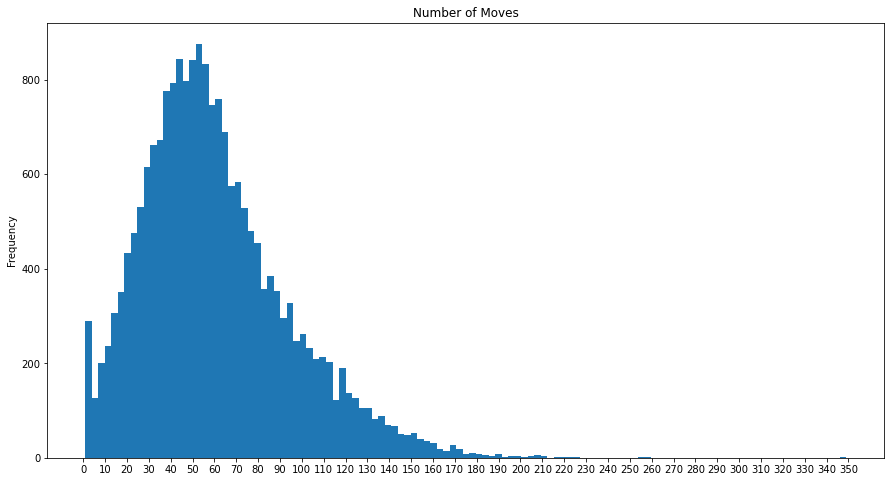

In [59]:
df['turns'].plot.hist(title='Number of Moves', bins=117, figsize=(15,8), xticks=range(0,351,10))

As shown by the histogram, there are around 300 games that have 0-3 moves, which represents a local maximum. This spike around 0 suggests that it is relatively common to start a new game accidentally, since there are many more games with 0-3 moves than in any of the bins from 3-12 moves. We will remove these 300 games from the dataset since it is almost certain that they ended due to external reasons.

In [74]:
df.drop(df[df['turns'] <= 3].index, inplace=True)

Here's what the turn data looks like after the omission.

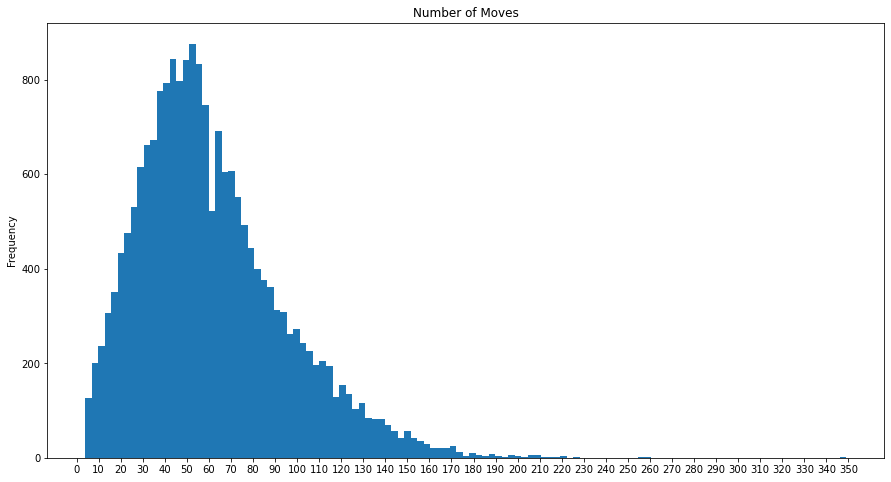

In [75]:
df['turns'].plot.hist(title='Number of Moves', bins=117, figsize=(15,8), xticks=range(0,351,10))

### Reformat columns

## Exploratory Data Analysis

We are going to explore some interesting correlations between opening moves and winning rate. Here, we are seeing if the material left in the first 10 moves can be a good predictor for winning.

In [61]:
df[['winner', 'turns', 'moves']].iloc[1][2]


'd4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6 Qe5+ Nxe5 c4 Bb4+'

In [62]:
def num_materials(moves):
    # white and black
    takes = [0, 0]
    for (i, move) in enumerate(moves.split(" ")):
        # 0 = white, 1 = black
        color = i % 2
        
        # determine if this was a take
        take = 'x' in move
        
        # add take to tuple
        takes[color] += 1 if take else 0
    
    return (16 - takes[1], 16 - takes[0])

In [63]:
materials_left = num_materials(df[['winner', 'turns', 'moves']].iloc[1][2])
materials_left

(13, 14)

In [9]:
board = [[0 for i in range(1, 9)] for j in range(1,9)]
board
'''
.
3
2
1
  a  b  c  d...
  
a1 = board[7][0]
h8 = board[0][7]
'''

# Function to map position on board to index of 2D array
def pos_to_ind(pos):
    x = pos[0]
    y = pos[1]
    
    # Kevin will write the if statements
    if x == 'a':
        x_ind = 7
    elif x == 'b':
        x_ind = 6
    elif x == 'c':
        x_ind = 5
    elif x == 'd':
        x_ind = 4
    elif x == 'e':
        x_ind = 3
    elif x == 'f':
        x_ind = 2
    elif x == 'g':
        x_ind = 1
    elif x == 'h':
        x_ind = 0
    
    return (x_ind, int(y) - 1)

print(pos_to_ind('h8'))

(0, 7)


In [5]:
adv_df = df.copy()[['turns', 'winner', 'moves']]
adv_df

,turns,winner,moves
0,13,white,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...
1,16,black,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...
2,61,white,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...
3,61,white,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...
4,95,white,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...
...,...,...,...
20053,24,white,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...
20054,82,black,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...
20055,35,white,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...
20056,109,white,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...


In [ ]:
def calc_pawn_adv(moves):
    
    
    
    # white and black
    takes = [0, 0]
    
    # Iterate through each turn
    for (i, move) in enumerate(moves.split(" ")):
        # 0 = white, 1 = black
        color = i % 2
        
        total_diff = 
    
    return total_diff / num_turns


#### Rating Differential

Another variable that we'll explore is the difference in rating between the two players. lichess.org uses the Glicko-2 rating system, which starts each player with a rating of 1500 and awards/removes points based on the outcomes of their matches. These rankings generally give a good indication of the skill of a player, so we'd expect that a player who has a higher ranking than their opponent is more likely to win by a margin roughly proportional to the difference in rank.

Here, we'll calculate the rating differential and get a sense of the distribution.

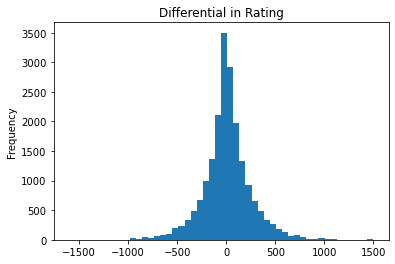

In [65]:
df['rating_diff'] = (df['white_rating']-df['black_rating'])
df['rating_diff'].plot.hist(title='Differential in Rating', bins=50)

It appears that differential in rating is symmetrically distributed and centered around zero, meaning that, on average, players should be evenly matched. To examine the effect of this differential on the outcome of the games, we will use qcut to split this Series into equally sized bins based on value, then plot the win rates of the bins against each other.

In [66]:
df['rating_bin'] = pd.qcut(df['rating_diff'], 5)

To compute average win rate, we'll need to convert the 'winner' column from a categorical variable into a number that can be averaged. We'll encode a victory for white as +1, victory for black as -1, and a draw as 0. With this encoding, a negative average would indicate that black has a higher winning rate for that bin, and vice versa for white.

In [69]:
df['win_ratio'] = df['winner'].replace({'black':-1, 'draw':0, 'white':1})

Finally, we'll group by the rating bin and compute the average win rate.

In [73]:
df_bin = df.groupby('rating_bin').mean()
df_bin

,rated,created_at,last_move_at,turns,white_rating,black_rating,opening_ply,rating_diff,win_ratio
rating_bin,,,,,,,,,
"(-1605.001, -146.0]",0.736922,1.481953e+12,1.481954e+12,59.142785,1442.118524,1765.393985,4.737427,-323.275461,-0.481173
"(-146.0, -29.0]",0.862601,1.485796e+12,1.485797e+12,64.087551,1548.759362,1627.842611,4.867915,-79.083249,-0.126265
"(-29.0, 39.0]",0.867503,1.487997e+12,1.487998e+12,64.025094,1589.107654,1584.605521,4.903388,4.502133,0.040151
"(39.0, 162.0]",0.845003,1.483758e+12,1.483759e+12,63.092846,1645.333841,1552.122527,4.877727,93.211314,0.226535
"(162.0, 1499.0]",0.719736,1.479823e+12,1.479824e+12,56.211597,1769.795015,1425.196846,4.916328,344.598169,0.562818


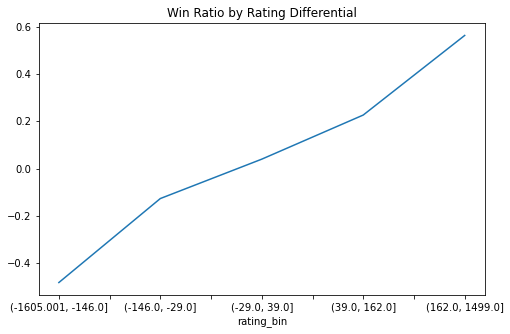

In [76]:
df_bin['win_ratio'].plot(title='Win Ratio by Rating Differential', figsize=(8,5))

As shown by the table and graph, there is a clear positive correlation between the win ratio and the rating differential between the two players. This trend makes a good deal of intuitive sense; if a player is higher rated than their opponent, they are more likely to win the match. The correlation suggests that the rating differential could be a useful variable to include in our evaluation model.